In [1]:
import os
import cv2
import numpy as np
from detection_utils import updatePoints, drawRoIPoly
from detection_utils import save2File, loadFile, getLaneMask
from detection_utils import warped2BirdPoly
import matplotlib.pyplot as plt
%matplotlib inline

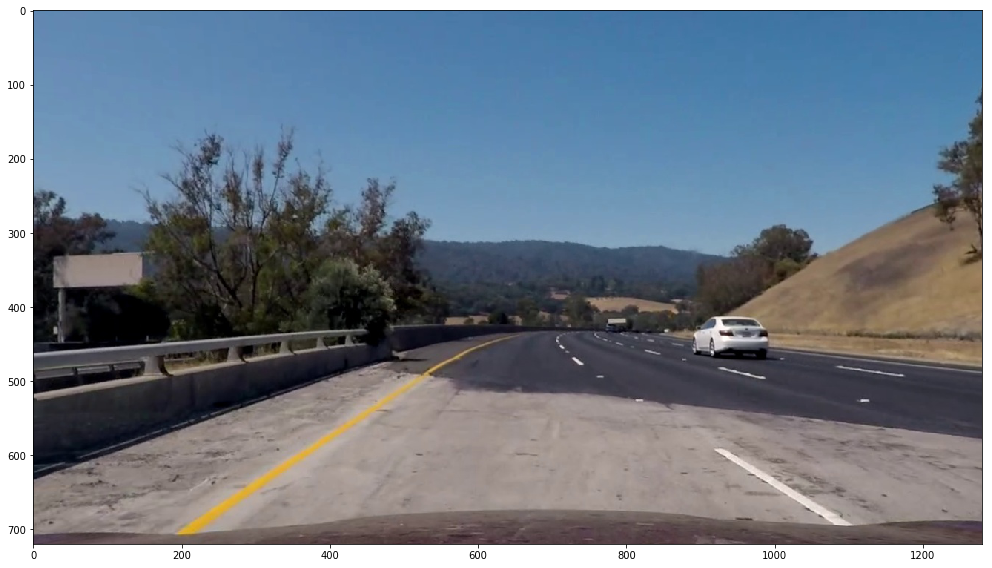

In [2]:
frame = plt.imread("./edge_thresh_calib/frame609.jpg")
plt.figure(figsize=(17, 17))
plt.imshow(frame)

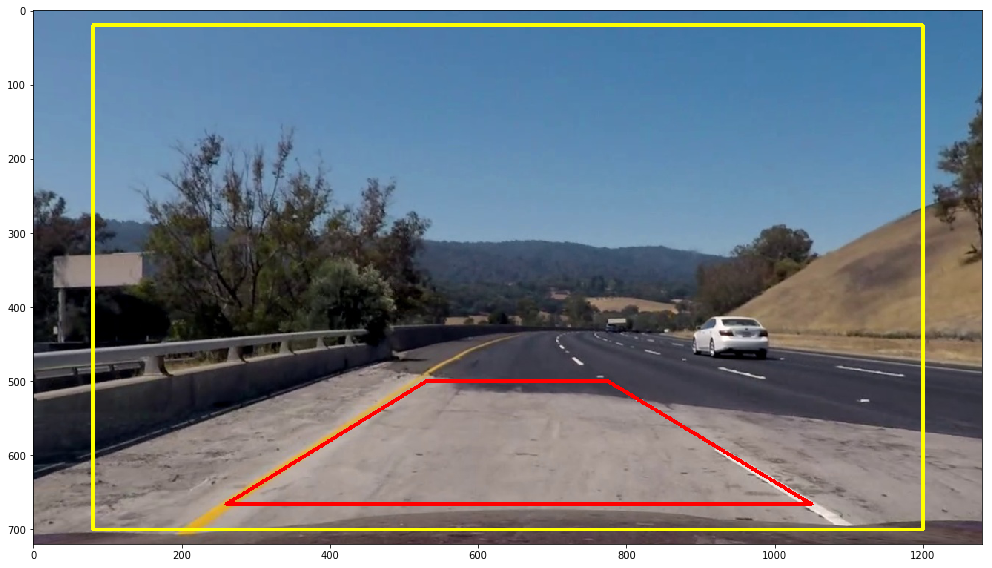

In [77]:
img = frame.copy()
src = np.array([(260, 666), (530, 500), (775, 500), (1050, 666)])
# dst = np.array([((260, 666), (260, 500), (1050, 500), (1050, 666))])
dst = np.array([((80, 700), (80, 20), (1200, 20), (1200, 700))])

cv2.polylines(img, [src], True, (255, 0, 0), 3)
cv2.polylines(img, [dst], True, (255, 255, 0), 3)
M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
outImg = cv2.warpPerspective(frame, M, (1280, 720), flags=cv2.INTER_LINEAR)
plt.figure(figsize=(17, 17))
plt.imshow(img)

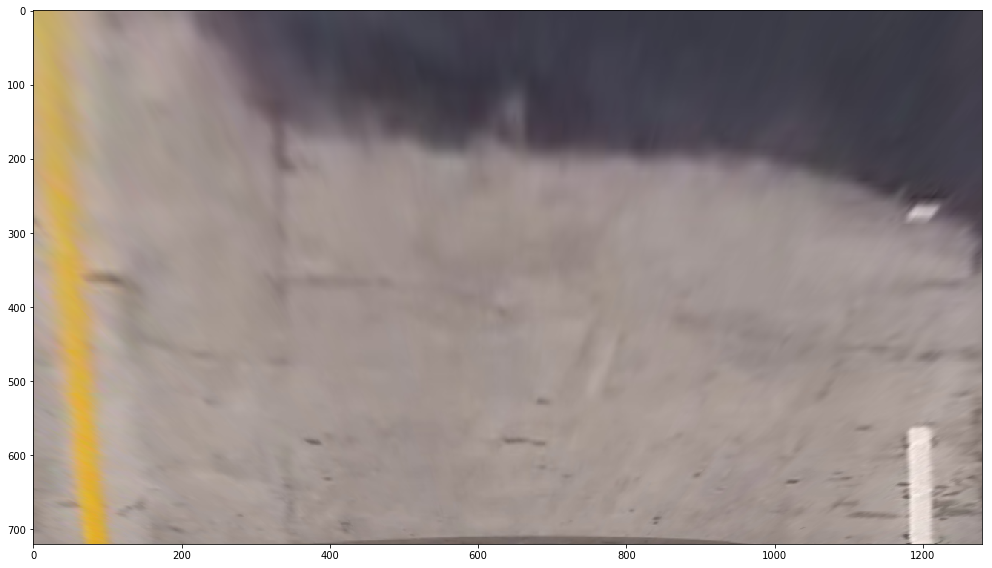

In [78]:
plt.figure(figsize=(17, 17))
plt.imshow(outImg)

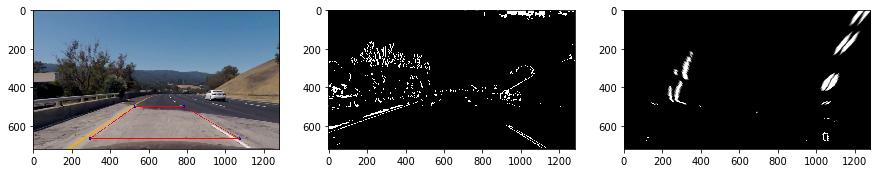

In [3]:
# frame = plt.imread("./edge_thresh_calib/frame558.jpg")
camModel = loadFile("camCalibMatCoeffs")
camMtx = camModel["camMtx"]
dstCoeffs = camModel["dstCoeffs"]
frame = cv2.undistort(frame, camMtx, dstCoeffs, None, camMtx)
displayedFrame = frame.copy()
if os.path.exists("./roiPoly"):
    points = loadFile("./roiPoly")
if points is not None:
    drawRoIPoly(displayedFrame, points)
    binaryLanes = getLaneMask(frame, 33, 200, 110, 30, 200)
    birdFrame = warped2BirdPoly(binaryLanes, points, 1280, 720)
# frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
# cv2.imshow("roiMask", roi)

fig = plt.figure(figsize=(15, 15))
axis = fig.add_subplot(1, 3, 1)
axis.imshow(displayedFrame)
axis = fig.add_subplot(1, 3, 2)
axis.imshow(binaryLanes, "gray")
axis = fig.add_subplot(1, 3, 3)
axis.imshow(birdFrame, "gray")


# Peaks in histogram

(342, 640, 1067)

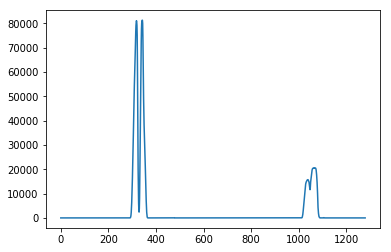

In [6]:
pixHisto = np.sum(birdFrame[birdFrame.shape[0]//2:], axis=0)
midPoint = pixHisto.shape[0]//2
leftPoint = np.argmax(pixHisto[:midPoint])
rightPoint = np.argmax(pixHisto[midPoint:]) + midPoint
plt.plot(pixHisto)
leftPoint, midPoint, rightPoint

In [4]:
def getinitialCenters(warpedFrame):
    xPixsHisto = np.sum(warpedFrame[warpedFrame.shape[0]//2:], axis=0)
    midPoint = xPixsHisto.shape[0]//2
    leftXcPoint = np.argmax(xPixsHisto[:midPoint])
    rightXcPoint = np.argmax(xPixsHisto[midPoint:]) + midPoint
    return leftXcPoint, rightXcPoint, xPixsHisto


def fitLaneLines(leftLinePoints, rightLinePoints, lineLength, order=2):
    leftX, leftY = leftLinePoints
    rightX, rightY = rightLinePoints
    leftLineParams = np.polyfit(leftY, leftX, order)
    rightLineParams = np.polyfit(rightY, rightX, order)
    save2File("linesFit", dict(leftParams=leftLineParams, rightParams=rightLineParams))
    lineYVals = np.linspace(0, lineLength, birdFrame.shape[0])
    leftLineXVals = leftLineParams[0]*lineYVals**2 + lineYVals*leftLineParams[1] + leftLineParams[2]
    rightLineXVals = rightLineParams[0]*lineYVals**2 + lineYVals*rightLineParams[1] + rightLineParams[2]
    return (leftLineXVals, lineYVals), (rightLineXVals, lineYVals)
    

def getLanePoints(warpedFrame, nWindows, windowWidth, pixelsThresh):
    leftLanePixelsIds = []
    rightLanePixelsIds = []
    noneZeroIds = warpedFrame.nonzero()
    noneZeroXIds = np.array(noneZeroIds[1])
    noneZeroYIds = np.array(noneZeroIds[0])
    leftXcPoint, rightXcPoint, xPixsHisto = getinitialCenters(warpedFrame)
    windowHeight = np.int(warpedFrame.shape[0] // nWindows)
    rightCenter = (rightXcPoint, warpedFrame.shape[0] - windowHeight//2)
    leftCenter = (leftXcPoint, warpedFrame.shape[0] - windowHeight//2)
    outImg = np.dstack([warpedFrame, warpedFrame, warpedFrame])
    
    for i in range(1, nWindows+1):
        leftLinePt1 = (leftCenter[0]-windowWidth//2, leftCenter[1]-windowHeight//2)
        leftLinePt2 = (leftCenter[0]+windowWidth//2, leftCenter[1]+windowHeight//2)
        rightLinePt1 = (rightCenter[0]-windowWidth//2, rightCenter[1]-windowHeight//2)
        rightLinePt2 = (rightCenter[0]+windowWidth//2, rightCenter[1]+windowHeight//2)
        cv2.rectangle(outImg, leftLinePt1, leftLinePt2, (0, 255, 0), 3)
        cv2.rectangle(outImg, rightLinePt1, rightLinePt2, (0, 255, 0), 3)

        leftWindowXIds = (noneZeroXIds > leftLinePt1[0]) & (noneZeroXIds < leftLinePt2[0])
        leftWindowYIds = (noneZeroYIds > leftLinePt1[1]) & (noneZeroYIds < leftLinePt2[1])
        leftWindowPoints = leftWindowXIds & leftWindowYIds
        rightWindowXIds = (noneZeroXIds > rightLinePt1[0]) & (noneZeroXIds < rightLinePt2[0])
        rightWindowYIds = (noneZeroYIds > rightLinePt1[1]) & (noneZeroYIds < rightLinePt2[1])
        rightWindowPoints = rightWindowXIds & rightWindowYIds

        leftLanePixelsIds.append(leftWindowPoints)
        rightLanePixelsIds.append(rightWindowPoints)

        leftCenter = leftCenter[0], leftCenter[1] - windowHeight
        if leftWindowPoints.sum() > pixelsThresh:
    #         xC = np.int(np.median(noneZeroXIds[leftWindowPoints]))
            lXc = np.int(noneZeroXIds[leftWindowPoints].mean())
            leftCenter = (lXc, leftCenter[1])

        rightCenter = rightCenter[0], rightCenter[1] - windowHeight
        if rightWindowPoints.sum() > pixelsThresh:
    #         xC = np.int(np.median(noneZeroXIds[leftWindowPoints]))
            rXc = np.int(noneZeroXIds[rightWindowPoints].mean())
            rightCenter = (rXc, rightCenter[1])

    leftLanePixelsIds = np.sum(np.array(leftLanePixelsIds), axis=0).astype("bool")
    rightLanePixelsIds = np.sum(np.array(rightLanePixelsIds), axis=0).astype("bool")
    leftX = noneZeroXIds[leftLanePixelsIds]
    leftY = noneZeroYIds[leftLanePixelsIds]
    rightX = noneZeroXIds[rightLanePixelsIds]
    rightY = noneZeroYIds[rightLanePixelsIds]
    outImg[leftY, leftX] = [255, 0, 0]
    outImg[rightY, rightX] = [0, 0, 255]
    return outImg, (leftX, leftY), (rightX, rightY)


roi is saved!


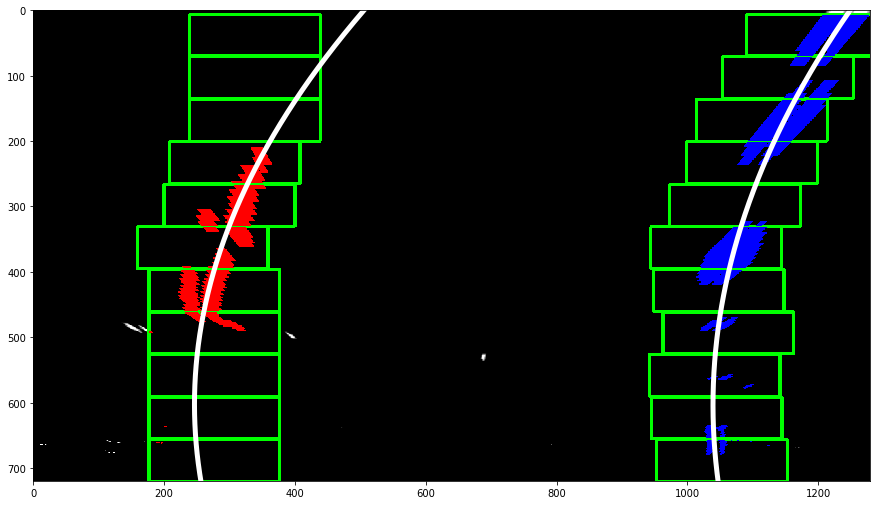

In [5]:
outImg, leftLinePoints, rightLinePoints = getLanePoints(birdFrame, 11, 200, 50)
leftLine, rightLine = fitLaneLines(leftLinePoints, rightLinePoints, birdFrame.shape[0]-1)

plt.figure(figsize=(15, 15))
plt.plot(*leftLine, "white", linewidth=5)
plt.plot(*rightLine, "white", linewidth=5)
plt.imshow(outImg)

In [6]:
def predictLaneLines(warpedFrame, linesParams, margin):
    leftLineParams = linesParams["leftParams"]
    rightLineParams = linesParams["rightParams"]
    noneZeroIds = warpedFrame.nonzero()
    noneZeroXIds = np.array(noneZeroIds[1])
    noneZeroYIds = np.array(noneZeroIds[0])
    outImg = np.dstack([warpedFrame, warpedFrame, warpedFrame])

    l_a, l_b, l_c = leftLineParams
    r_a, r_b, r_c = rightLineParams
    leftLineLBoundry = l_a*noneZeroYIds**2 + l_b*noneZeroYIds + l_c - margin
    leftLineRBoundry = l_a*noneZeroYIds**2 + l_b*noneZeroYIds + l_c + margin
    rightLineLBoundry = r_a*noneZeroYIds**2 + r_b*noneZeroYIds + r_c - margin
    rightLineRBoundry = r_a*noneZeroYIds**2 + r_b*noneZeroYIds + r_c + margin

    leftLineBoundryIds = (noneZeroXIds > leftLineLBoundry) & (noneZeroXIds < leftLineRBoundry)
    rightLineBoundryIds = (noneZeroXIds > rightLineLBoundry) & (noneZeroXIds < rightLineRBoundry)

    leftLineBoundryX = noneZeroXIds[leftLineBoundryIds]
    leftLineBoundryY = noneZeroYIds[leftLineBoundryIds]
    rightLineBoundryX = noneZeroXIds[rightLineBoundryIds]
    rightLineBoundryY = noneZeroYIds[rightLineBoundryIds]

    outImg[leftLineBoundryY, leftLineBoundryX] = [255, 0, 0]
    outImg[rightLineBoundryY, rightLineBoundryX] = [0, 0, 255]
    leftLine, rightLine = fitLaneLines(
        (leftLineBoundryX, leftLineBoundryY), 
        (rightLineBoundryX, rightLineBoundryY), 
        birdFrame.shape[0]-1
    )
    return outImg, leftLine, rightLine


def plotPredictionBoundry(warpedImg, leftLine, rightLine, margin):
    boundryMask = np.zeros_like(warpedImg)
    leftLineLeftMargin = leftLine[0] - margin, leftLine[1]
    leftLineRightMargin = leftLine[0] + margin, leftLine[1]
    rightLineLeftMargin = rightLine[0] - margin, rightLine[1]
    rightLineRightMargin = rightLine[0] + margin, rightLine[1]

    leftLineLeftMargin = np.array(list(zip(*leftLineLeftMargin)), "int")
    leftLineRightMargin = np.flipud(np.array(list(zip(*leftLineRightMargin)), "int"))
    leftBoundry = list(np.vstack([leftLineLeftMargin, leftLineRightMargin]).reshape(1, -1, 2))
    cv2.fillPoly(boundryMask, leftBoundry, (255, 255, 0))

    rightLineLeftMargin = np.array(list(zip(*rightLineLeftMargin)), "int")
    rightLineRightMargin = np.flipud(np.array(list(zip(*rightLineRightMargin)), "int"))
    rightBoundry = list(np.vstack([rightLineLeftMargin, rightLineRightMargin]).reshape(1, -1, 2))
    cv2.fillPoly(boundryMask, rightBoundry, (255, 255, 0))
    outImg = cv2.addWeighted(warpedImg, 1, boundryMask, 0.2, 0)
    return outImg


roi is saved!


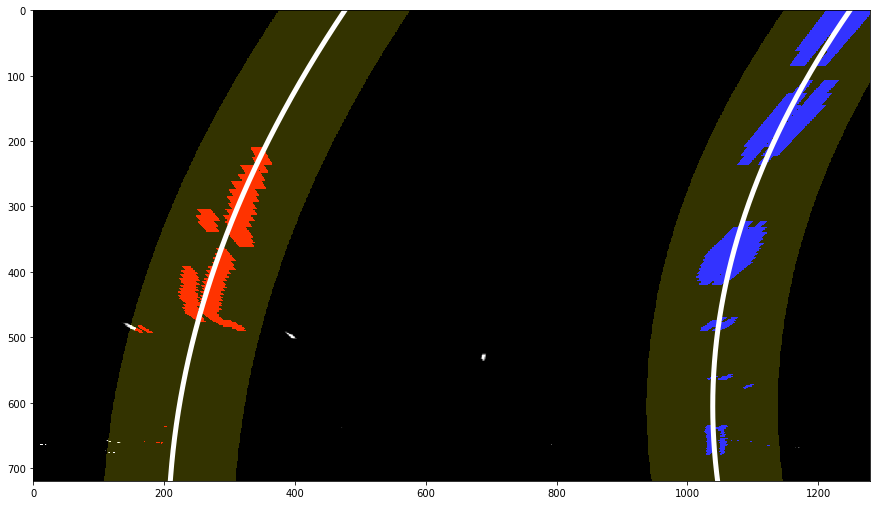

In [7]:
margin = 100
linesParams = loadFile("./linesFit")
outImg, leftLine, rightLine = predictLaneLines(birdFrame, linesParams, margin)

outImg = plotPredictionBoundry(outImg, leftLine, rightLine, margin)
plt.figure(figsize=(15, 15))
plt.plot(*leftLine, "white", linewidth=5)
plt.plot(*rightLine, "white", linewidth=5)

plt.imshow(outImg)

# Advanced Lane Convoluted Search
Comes useful for extreme lane curvature perfect fitting

In [8]:
def predictXVal(y, params):
    a, b , c = params
    return a*y**2 + b*y + c


def measureCurveRadius(y, params):
    a, b , c = params
    x = predictXVal(y, params)
    dydx = 2*a*y + b
    d2ydx2 = 2*a
    r = ((1 + (dydx**2))**1.5)/d2ydx2
    return r


In [9]:
measureCurveRadius(350, linesParams["leftParams"])

841.4308093923454